# Uniqueness based on place365 scenes

In [1]:
import torch
import torchvision

import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt

from src.dataset import AirbnbDataset, AirbnbNYDataset
        

def print_w_scenes(ds, uniqueness, indices=None, scene="bedroom", most_unique=1000, most_common=None, seed=42, display_index=True):
    np.random.seed(seed)
    
    ## get top-k unique images
    if indices is None:
        uniqueness = uniqueness[uniqueness["scene"]==scene]    
        if most_unique is not None:
            samples = uniqueness.nsmallest(most_unique, columns=["loss"])
        if most_common is not None:
            samples = uniqueness.nlargest(most_common, columns=["loss"])
        indices = samples.sample(30).index
    else:
        samples = uniqueness.reindex(indices)
    if display_index:
        display(indices.to_frame())

    # load the test image
    if isinstance(indices, pd.MultiIndex):
        mapping = ds.idx_mapping.reset_index().set_index(["idx_image","image_id"])
    else:
        mapping = ds.idx_mapping.reset_index().set_index("image_id")
    
    prefix = "most common in" if most_common else "most unique in"
    print(f"{prefix} scene: {scene}")
    rows = int(len(indices) // 10)
    rows = 1 if rows == 0 else rows
    fig = plt.figure(figsize=(20, 3 * rows - 1))
    for i, it in enumerate(indices):
        ax = fig.add_subplot(rows, 10, i+1)
        idx = mapping.loc[it]["index"]
        img = ds[idx]["image"].reshape(224, 224, 3).astype('uint8')

        # plot
        plt.imshow(img)
        ax.set_title(f"score:{samples.iloc[i,0]:.1f}")
        plt.axis('off')
        plt.tight_layout()

        
        

In [2]:
## uniqueness file
# "./output/06-22_19:15:53/"
file_path = "./output/08-05_01:37:26"

# inpath = "/export/projects2/szhang_text_project/Airbnb_unique/photo_library/"
inpath = "/export/projects2/szhang_text_project/Airbnb_Images_NYC/photos.hdf5"

uniqueness = pd.read_pickle(file_path + "/uniqueness.pkl")
ds = AirbnbNYDataset(inpath)

idx = uniqueness[uniqueness["scene"]=="bedroom"].index
t = pd.read_pickle(file_path + "/train_loss.pkl").reindex(idx)["loss"]
uniqueness.loc[idx, "loss"] = t.values

,,property_id,image_id
property_id,image_id,,
52949093,miso#Hosting-52949093#original#1a858b88-c61f-46a8-9f75-86f14f65e621.jpeg,52949093,miso#Hosting-52949093#original#1a858b88-c61f-4...
40409517,714dbbeb-aef1-4037-b447-437d732ea435,40409517,714dbbeb-aef1-4037-b447-437d732ea435
52440803,58c3ef38-d894-4d09-86b3-3a9b7c1e9e0f,52440803,58c3ef38-d894-4d09-86b3-3a9b7c1e9e0f
749276,13230786#424112d6_original,749276,13230786#424112d6_original
10233563,f1d72fc9-71bd-4211-bca2-4efe0e7a3a74,10233563,f1d72fc9-71bd-4211-bca2-4efe0e7a3a74
46480260,prohost-api#Hosting-46480260#original#15a1e851-5c4f-44d0-a3b9-31a4097ea9ad.jpeg,46480260,prohost-api#Hosting-46480260#original#15a1e851...
52206067,87130719-c4c4-494b-9062-b87dc045a8d7,52206067,87130719-c4c4-494b-9062-b87dc045a8d7
51548261,prohost-api#Hosting-51548261#original#1637163a-3374-4d15-88ea-0e90f558fc02.jpeg,51548261,prohost-api#Hosting-51548261#original#1637163a...
18199525,a82a254d-ae60-4954-ae1e-0d15eb096821,18199525,a82a254d-ae60-4954-ae1e-0d15eb096821


most unique in scene: bedroom


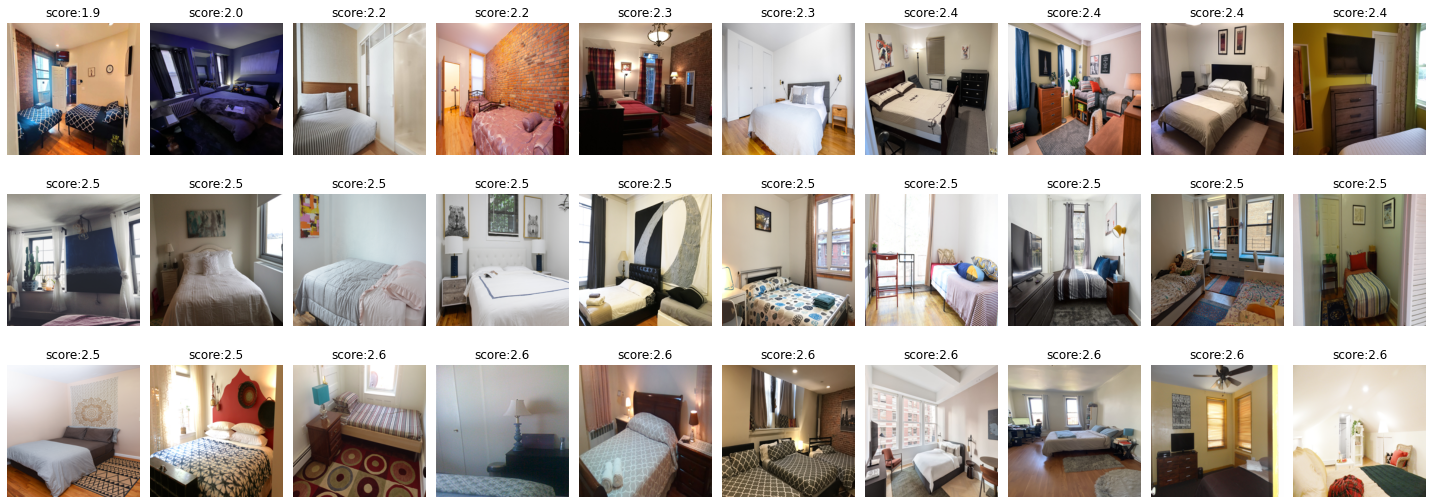

In [26]:
print_w_scenes(ds, uniqueness, scene="bedroom", most_unique=5000, most_common=None, seed=1)

,,property_id,image_id
property_id,image_id,,
26874261,b8772f44-6f71-40f1-be26-b422c7fd0eba,26874261,b8772f44-6f71-40f1-be26-b422c7fd0eba
33908121,b116ca97-4ae4-49b0-8d32-11aad7045e88,33908121,b116ca97-4ae4-49b0-8d32-11aad7045e88
13688888,8fa1d075-2b81-4710-97d4-32df795e7848,13688888,8fa1d075-2b81-4710-97d4-32df795e7848
39398034,prohost-api#Hosting-39398034#original#70c77e8f-87b8-4856-9dda-b52cd6abefb8.jpeg,39398034,prohost-api#Hosting-39398034#original#70c77e8f...
467569,fd419aeb-9809-4bc2-bc55-2ce9447e9cf7,467569,fd419aeb-9809-4bc2-bc55-2ce9447e9cf7
29170235,e3216033-ac38-4d03-b211-7f7eb916d8ca,29170235,e3216033-ac38-4d03-b211-7f7eb916d8ca
31388864,f816b1d5-547a-4452-9c26-89d657021e7a,31388864,f816b1d5-547a-4452-9c26-89d657021e7a
48980478,8b91c9ab-5545-4f6a-8099-ae466ae03a7c,48980478,8b91c9ab-5545-4f6a-8099-ae466ae03a7c
14109544,65afddb7-29fd-4eca-aa56-72731c626e98,14109544,65afddb7-29fd-4eca-aa56-72731c626e98


most common in scene: bedroom


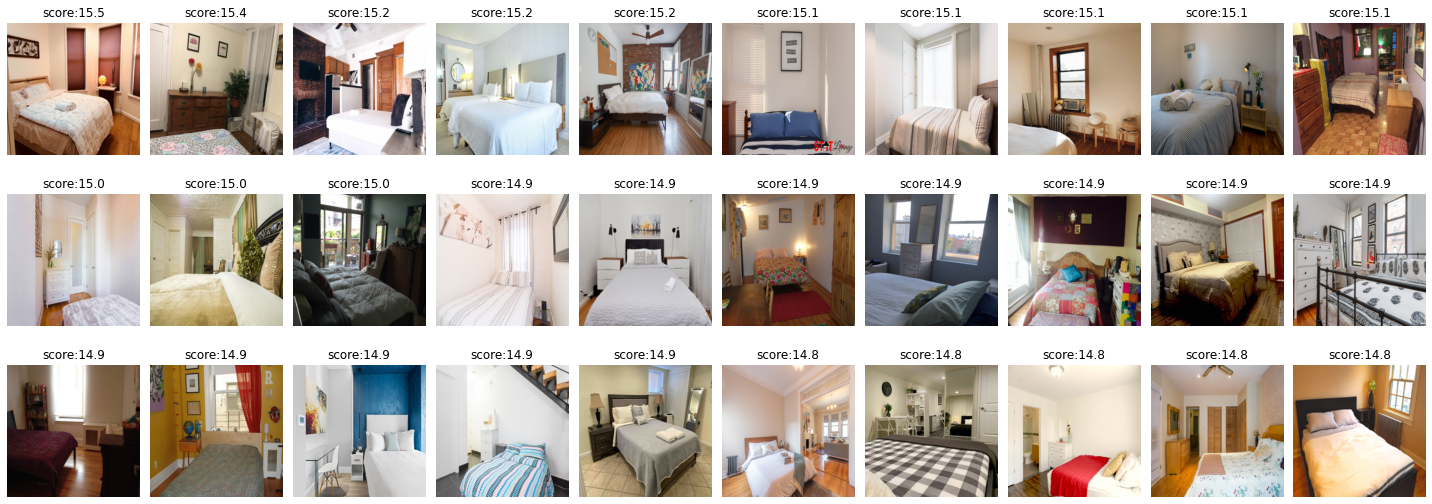

In [19]:
print_w_scenes(ds, uniqueness, scene="bedroom", most_unique=None, most_common=30000, seed=1)

In [6]:
uniqueness

loss  in/out  \
property_id image_id                                                  
10000070    1ab76ac0-ff38-413d-a0d9-c9684e9567e5  12.812914       0   
            3b1fecf5-4645-4647-92c0-5bd84c946c35   9.611490       0   
            4dbcbd86-1f1a-42ec-b29c-0fbdb83d414b   6.214094       0   
            502a6ad0-03bf-4358-bc81-3c8893042656  12.858687       0   
            6efb9d2a-f0da-42b5-b6fa-dc16fc765742   4.446893       0   
...                                                     ...     ...   
999984      15029590#bdda606e_original             8.762262       0   
            15029616#a02624b6_original             9.982172       0   
            15029635#f3e419ee_original            11.470390       0   
            15029662#532a14c1_original            12.177086       0   
            15031181#3e477c2c_original             5.568415       0   

                                                              scene      prob  
property_id image_id                                                           
10000070    1ab76ac0-ff38-413d-a0d9-c9684e9567e5            archive  0.793852  
            3b1fecf5-4645-4647-92c0-5bd84c946c35        art_gallery  0.998411  
            4dbcbd86-1f1a-42ec-b29c-0fbdb83d414b           playroom  0.681102  
            502a6ad0-03bf-4358-bc81-3c8893042656       artists_loft  0.837033  
            6efb9d2a-f0da-42b5-b6fa-dc16fc765742      museum/indoor  0.766493  
...                                                             ...       ...  
999984      15029590#bdda606e_original            bow_window/indoor  0.648984  
            15029616#a02624b6_original                      kitchen  0.999764  
            15029635#f3e419ee_original                      kitchen  0.999896  
            15029662#532a14c1_original                  living_room  0.930379  
            15031181#3e477c2c_original                  living_room  0.952550  

[454023 rows x 4 columns]

# Show where is unique

In [18]:
import argparse
import json
import os
from datetime import datetime

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F


from PIL import Image, ImageFile
from tqdm import tqdm
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

import src.model
import src.dataset

ImageFile.LOAD_TRUNCATED_IMAGES = True
device = "cuda" if torch.cuda.is_available() else "cpu"

def set_seed(seed=42, cuda_deterministic=True):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    if cuda_deterministic:  # slower, more reproducible
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:  # faster, less reproducible
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True


def load_state_dict_unsafe(model, state_dict):
    """
    Load state dict to provided model while ignore exceptions.
    """

    missing_keys = []
    unexpected_keys = []
    error_msgs = []

    # copy state_dict so _load_from_state_dict can modify it
    metadata = getattr(state_dict, "_metadata", None)
    state_dict = state_dict.copy()
    if metadata is not None:
        state_dict._metadata = metadata

    def load(module, prefix=""):
        local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
        module._load_from_state_dict(
            state_dict,
            prefix,
            local_metadata,
            True,
            missing_keys,
            unexpected_keys,
            error_msgs,
        )
        for name, child in module._modules.items():
            if child is not None:
                load(child, prefix + name + ".")

    load(model)
    load = None  # break load->load reference cycle

    return {
        "unexpected_keys": unexpected_keys,
        "missing_keys": missing_keys,
        "error_msgs": error_msgs,
    }


class RELAX(nn.Module):
    def __init__(self, x, f, num_batches, batch_size):
        super().__init__()

        self.batch_size = batch_size
        self.shape = tuple(x.shape[2:])
        self.num_batches = num_batches
        self.pdist = nn.CosineSimilarity(dim=1)

        self.x = x
        self.encoder = f
        h_star = f(self.x)
        self.h_star = h_star.expand(batch_size, -1)

        self.R = torch.zeros(self.shape, device=device)
        self.U = torch.zeros(self.shape, device=device)

        self.sum_of_weights = (1e-10)*torch.ones(self.shape, device=device)

    def forward(self):

        for batch in range(self.num_batches):
            for masks in self.mask_generator():

                x_mask = self.x * masks
                h = self.encoder(x_mask)
                sims = self.pdist(self.h_star, h)

                for si, mi in zip(sims, masks.squeeze()):

                    W_prev = self.sum_of_weights
                    self.sum_of_weights += mi

                    R_prev = self.R.clone()
                    self.R = self.R + mi*(si-self.R) / self.sum_of_weights
                    self.U = self.U + (si-self.R) * (si-R_prev) * mi

        return None

    def importance(self):
        return self.R

    def uncertainty(self):
        return self.U / (self.sum_of_weights - 1)

    def mask_generator(self, num_cells=7, p=0.5, nsd=2):

        pad_size = (num_cells // 2, num_cells // 2, num_cells // 2, num_cells // 2)

        grid = (torch.rand(self.batch_size, 1, *((num_cells,) * nsd), device=device) < p).float()
        grid_up = F.interpolate(grid, size=(self.shape), mode='bilinear', align_corners=False)
        grid_up = F.pad(grid_up, pad_size, mode='reflect')

        shift_x = torch.randint(0, num_cells, (self.batch_size,), device=device)
        shift_y = torch.randint(0, num_cells, (self.batch_size,), device=device)

        masks = torch.empty((self.batch_size, 1, self.shape[-2], self.shape[-1]), device=device)

        for bi in range(self.batch_size):
            masks[bi] = grid_up[bi, :,
                                shift_x[bi]:shift_x[bi] + self.shape[-2],
                                shift_y[bi]:shift_y[bi] + self.shape[-1]]

        yield masks
        
        
def get_RELAX_list(ds, uniqueness, model, indices, scene, most_unique, most_common, seed):
    
    np.random.seed(seed)
    ## get top-k unique images
    if indices is None:
        uniqueness = uniqueness[uniqueness["scene"]==scene]    
        if most_unique is not None:
            samples = uniqueness.nsmallest(most_unique, columns=["loss"])
        if most_common is not None:
            samples = uniqueness.nlargest(most_common, columns=["loss"])
        indices = np.random.choice(samples.index.tolist(),30,replace=False)
    else:
        samples = uniqueness.reindex(indices)

    if isinstance(indices, pd.MultiIndex):
        mapping = ds.idx_mapping.reset_index().set_index(["idx_image","image_id"])
    else:
        mapping = ds.idx_mapping.reset_index().set_index("image_id")

    ## inference
    relax_list = []
    tsfm_imgs, raw = [], []
    mask_bs = 100
    num_batches = 30

    for idx in tqdm(indices):
        x = ds[mapping.loc[idx]["index"]]["image"]
        tsfm = torchvision.transforms.Compose([
            torchvision.transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ])
        x = tsfm(torchvision.transforms.ToPILImage()(x)).reshape(1, 3, 224, 224)
        tsfm_imgs.append(x)

        with torch.no_grad():
            relax = RELAX(x, model, num_batches, mask_bs)
            relax.forward()

        relax_list.append(relax)
        
    return relax_list, tsfm_imgs, indices
    
        
def show_RELAX(ds, uniqueness, model, indices=None, scene="bedroom", most_unique=1000, most_common=None, seed=42):
    relax_list, tsfm_imgs, indices = get_RELAX_list(ds, uniqueness, model, indices, scene, most_unique, most_common, seed)
    def to_np(x):
        return x.cpu().detach().numpy()

    def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
        if isinstance(img, Image.Image):
            img = pil_to_tensor(img)
        handle = None
        with torch.no_grad():
            if not lim:
                lim = [img.min(), img.max()]
            img = img - lim[0]  # also makes a copy
            img.mul_(1 / (lim[1] - lim[0]))
            img = torch.clamp(img, min=0, max=1)
            if not quiet:
                bitmap = img.expand(3,
                            *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
        return bitmap

    fig = plt.figure(1, figsize=(16, 8))
    font_size = 15

    gs = gridspec.GridSpec(6, 20)

    for i, (model_explanation, idx) in enumerate(zip(relax_list, indices)):

        ax = plt.subplot(gs[0:2, 2*(i):2*(1+i)])
        if i == 0: 
            ax.set_ylabel('Importance', fontsize=font_size)

        ax.imshow(imsc(tsfm_imgs[i].squeeze()))
        im = ax.imshow(to_np(model_explanation.importance()), alpha=0.75, cmap='bwr')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"score:{uniqueness.loc[idx][0]:.2f}", fontsize=font_size)

        ax = plt.subplot(gs[2:4, 2*(i):2*(1+i)])
        if i == 0: ax.set_ylabel('Uncertainty', fontsize=font_size)

        ax.imshow(imsc(tsfm_imgs[i].squeeze()))

        ax.imshow(to_np(model_explanation.uncertainty()), alpha=0.75, cmap='bwr')
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.set_title(idx, fontsize=font_size)

        ax = plt.subplot(gs[4:6, 2*(i):2*(1+i)])
        if i == 0: ax.set_ylabel('Raw', fontsize=font_size)

        ax.imshow(imsc(tsfm_imgs[i].squeeze()))
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.set_title(idx, fontsize=font_size)

    plt.tight_layout()

    cbar_ax = fig.add_axes([0.98, 0.05, 0.01, 0.86])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_ticks([])

    plt.tight_layout()
    plt.show()


In [15]:
## uniqueness file
file_path = "./output/08-05_01:37:26" # "./output/06-22_19:15:53/"
uniqueness = pd.read_pickle(file_path + "/uniqueness.pkl")

## load model
model = src.model.MoCo(torchvision.models.__dict__["resnet18"], K=65280)
res = load_state_dict_unsafe(
        model, torch.load(file_path + "/model.pt", map_location="cpu")
    )
model = model.encoder_q
model.fc = nn.Linear(512, 128, bias=False)

## dataset
# inpath = "/export/projects2/szhang_text_project/Airbnb_unique/photo_library/"
inpath = "/export/projects2/szhang_text_project/Airbnb_Images_NYC/photos.hdf5"
ds = AirbnbNYDataset(inpath)

## Eyeballing and Sampling here 

In [12]:
idx_unique = {
    "bedroom": pd.MultiIndex.from_tuples([("40409517","714dbbeb-aef1-4037-b447-437d732ea435"),]), 
    "kitchen": pd.MultiIndex.from_tuples([None]),
    "living_room": pd.MultiIndex.from_tuples([None]),
    "bathroom": pd.MultiIndex.from_tuples([None]),
}

idx_common = {
    "bedroom": pd.MultiIndex.from_tuples([("39398034","prohost-api#Hosting-39398034#original#70c77e8f-87b8-4856-9dda-b52cd6abefb8.jpeg"), ]),
    "kitchen": pd.MultiIndex.from_tuples([None]),
    "living_room": pd.MultiIndex.from_tuples([None]),
    "bathroom": pd.MultiIndex.from_tuples([None]),
}


most unique in scene: bedroom
most unique in scene: kitchen
most unique in scene: living_room
most unique in scene: bathroom


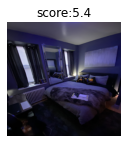

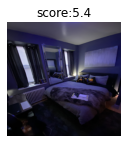

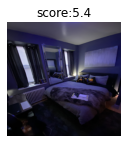

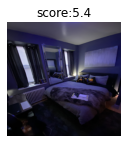

In [46]:
print_w_scenes(ds, uniqueness, indices=idx_unique["bedroom"], scene="bedroom", most_unique=1, most_common=None, display_index=False)
print_w_scenes(ds, uniqueness, indices=idx_unique["kitchen"], scene="kitchen", most_unique=1, most_common=None, display_index=False)
print_w_scenes(ds, uniqueness, indices=idx_unique["living_room"], scene="living_room", most_unique=1, most_common=None, display_index=False)
print_w_scenes(ds, uniqueness, indices=idx_unique["bathroom"], scene="bathroom", most_unique=1, most_common=None, display_index=False)


In [1]:
print_w_scenes(ds, uniqueness, indices=idx_common["bedroom"], scene="bedroom", most_unique=None, most_common=1, display_index=False)
print_w_scenes(ds, uniqueness, indices=idx_common["kitchen"], scene="kitchen", most_unique=None, most_common=1, display_index=False)
print_w_scenes(ds, uniqueness, indices=idx_common["living_room"], scene="living_room", most_unique=None, most_common=1, display_index=False)
print_w_scenes(ds, uniqueness, indices=idx_common["bathroom"], scene="bathroom", most_unique=None, most_common=1, display_index=False)


## RELAX-Common

100%|██████████| 1/1 [00:45<00:00, 45.33s/it]
<ipython-input-18-6a61e14b5261>:251: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


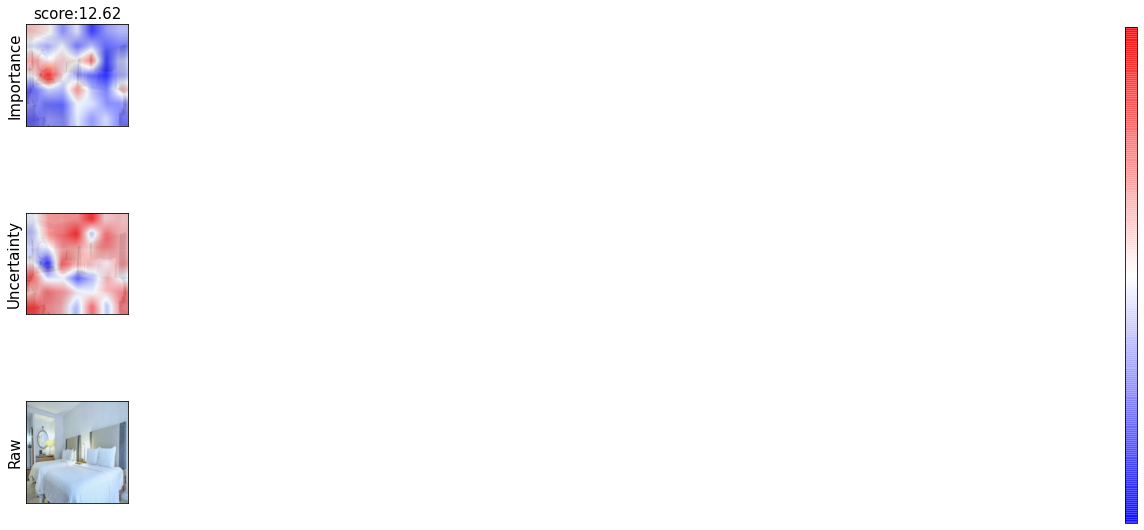

In [19]:
show_RELAX(ds, uniqueness, model, indices=idx_common["bedroom"], scene="bedroom", most_unique=None, most_common=1)

In [22]:
show_RELAX(ds, uniqueness, model, indices=idx_common["kitchen"], scene="kitchen", most_unique=None, most_common=1)

In [23]:
show_RELAX(ds, uniqueness, model, indices=idx_common["living_room"], scene="living_room", most_unique=None, most_common=1)

In [24]:
show_RELAX(ds, uniqueness, model, indices=idx_common["bathroom"], scene="bathroom", most_unique=None, most_common=1)

## RELAX-Unique

100%|██████████| 1/1 [00:45<00:00, 45.45s/it]
<ipython-input-18-6a61e14b5261>:251: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


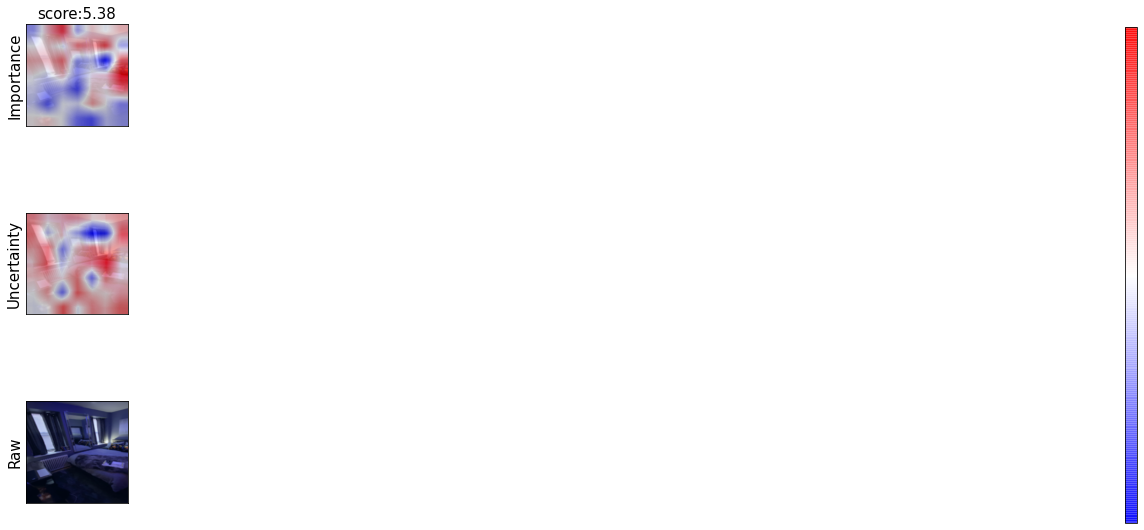

In [30]:
show_RELAX(ds, uniqueness, model, indices=idx_unique["bedroom"], scene="bedroom", most_unique=1, most_common=None)

In [26]:
show_RELAX(ds, uniqueness, model, indices=idx_unique["kitchen"], scene="kitchen", most_unique=1, most_common=None)

In [27]:
show_RELAX(ds, uniqueness, model, indices=idx_unique["living_room"], scene="living_room", most_unique=1, most_common=None)

In [28]:
show_RELAX(ds, uniqueness, model, indices=idx_unique["bathroom"], scene="bathroom", most_unique=1, most_common=None)

# Analysis of Uniqueness

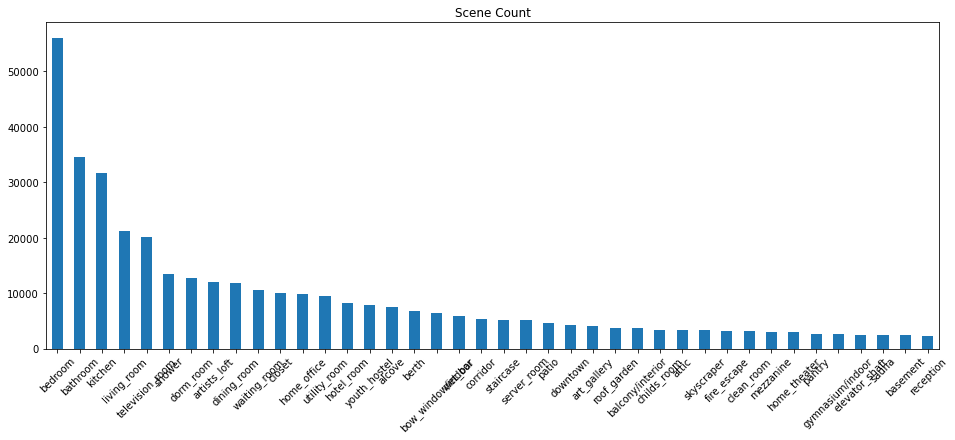

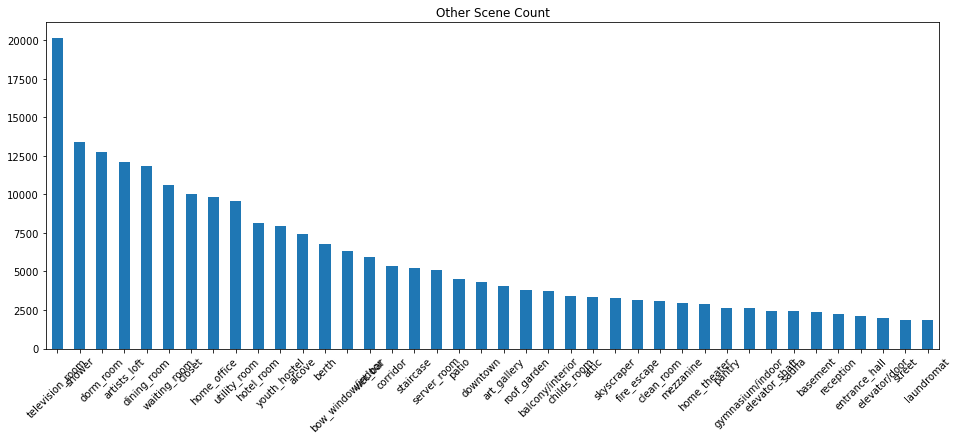

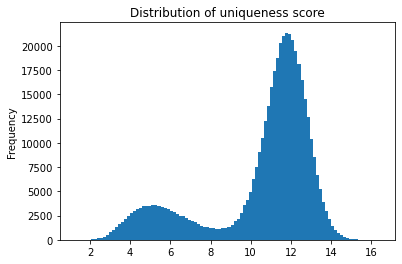

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## uniqueness file
file_path="./output/08-05_01:37:26/"
uniqueness = pd.read_pickle(file_path + "/uniqueness.pkl")

plt.figure(figsize=(16,6))
_ = uniqueness.iloc[:,2].value_counts()[:40].plot.bar(rot=45, title="Scene Count")
plt.figure(figsize=(16,6))
_ = uniqueness[~uniqueness.scene.isin(["bedroom","bathroom","living_room","kitchen"])].iloc[:,2].value_counts()[:40].plot.bar(rot=45, title="Other Scene Count")
plt.figure()
_ = uniqueness.loss.plot.hist(bins=100,title="Distribution of uniqueness score")

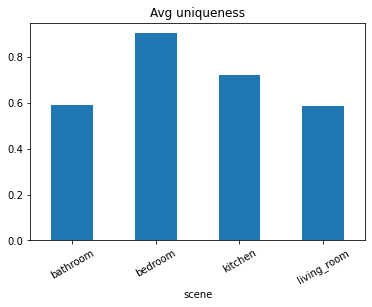

In [2]:
## Average uniqueness ranked by scenes
t = uniqueness.copy()
t["loss"] = t["loss"].sub(uniqueness.groupby("scene")["loss"].transform("mean"))
t = t.groupby("scene")["loss"].mean().rank(pct=True)
_ = t[t.index.isin(["bedroom","bathroom","living_room","kitchen"])].plot.bar(rot=30,title="Avg uniqueness")

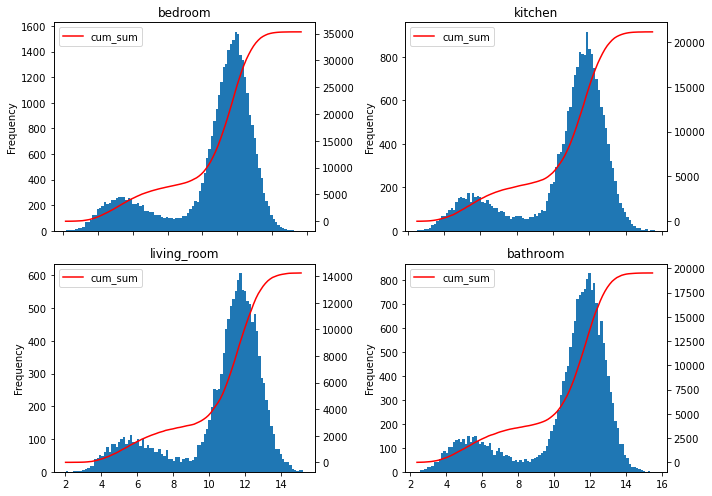

In [5]:
def plot_scene_dist(uniqueness, ax, scene="bedroom"):
    idx = uniqueness["scene"]==scene
    uniqueness[idx]["loss"].plot.hist(bins=100,title=scene,ax=ax)
    ax2 = ax.twinx()
    t = pd.cut(uniqueness[idx]["loss"],100).value_counts()
    t.index = [i.left for i in t.index]
    t.name = "cum_sum"
    t = t.sort_index()
    np.cumsum(t).plot(ax=ax2, color="r", legend=True)
    
    
fig,ax = plt.subplots(2,2,figsize=(10,7))
plot_scene_dist(uniqueness, ax[0,0], "bedroom")
plot_scene_dist(uniqueness, ax[0,1], "kitchen")
plot_scene_dist(uniqueness, ax[1,0], "living_room")
plot_scene_dist(uniqueness, ax[1,1], "bathroom")
plt.tight_layout()

In [6]:
print(t.sort_values())

scene
marsh             0.005525
soccer_field      0.005525
water_park        0.005525
lobby             0.011050
pavilion          0.013812
                    ...   
plaza             0.988950
alley             0.991713
yard              0.994475
elevator_lobby    0.997238
hardware_store    1.000000
Name: loss, Length: 362, dtype: float64
